In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import auc, mean_squared_error, mean_squared_log_error, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, label_binarize
from sklearn.linear_model import Ridge

from keras import models, layers, Sequential
from keras.layers import Dense, Activation
from keras.initializers import GlorotNormal

# seed 고정

In [3]:
import tensorflow as tf
tf.random.set_seed(1234)
np.random.seed(1234)

# DATA LOAD

In [4]:
from keras.datasets import mnist

In [5]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

In [6]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
X_train[:1], y_train[:1]
# 0 : 검은색 , 255: 흰색
# 0-255값

(array([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            3,  18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,
     

# EDA

## imshow

- <b>matplotlib.pyplot.imshow(X, cmap=None,</b> norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)

- ref : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

- 픽셀 좌표를 행렬로 가지고 있어야함
<pre>
z = 픽셀 값을 갖는 행렬
plt.imshow(Z)
plt.show()

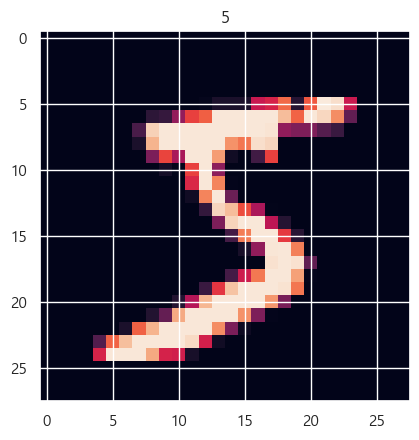

In [8]:
plt.imshow(X_train[0])
plt.title(y_train[0])
plt.show()

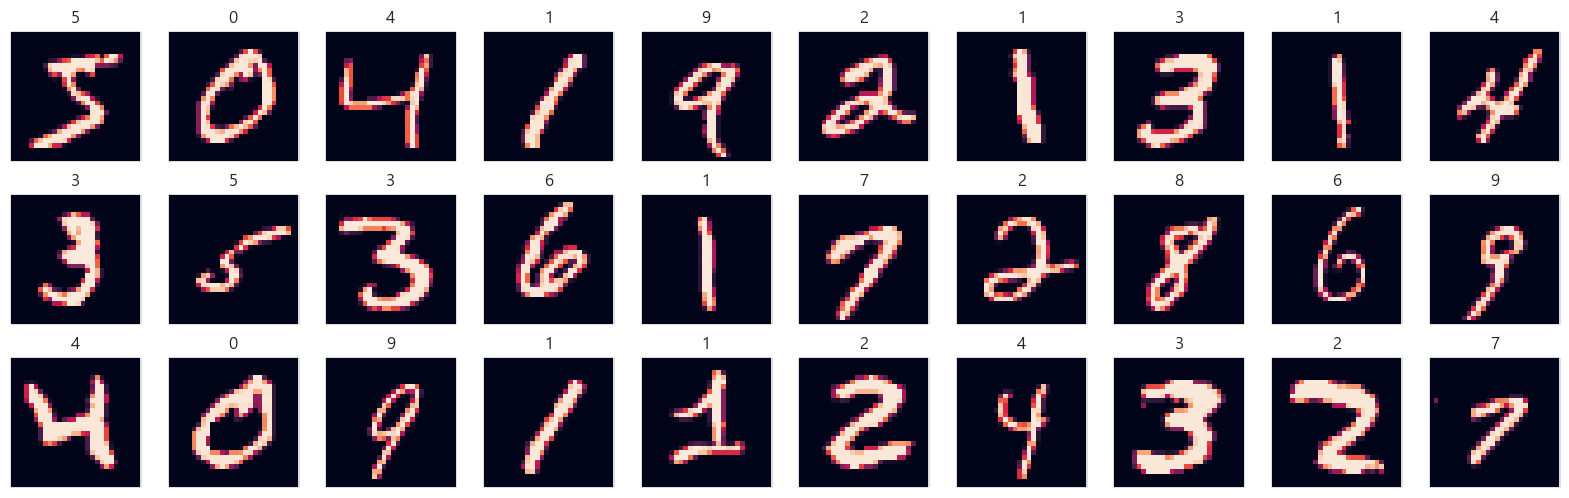

In [9]:
fig,ax = plt.subplots(3,10, figsize = (20,6))
for i in range(30):
    r = i//10
    c = i%10
    ax[r][c].imshow(X_train[i])
    ax[r][c].set_title(y_train[i])
    
    # Hide axes,grid ==========
    ax[r][c].grid(False)
    ax[r][c].set_xticks([])
    ax[r][c].set_yticks([])
    # =========================

plt.show()

In [10]:
pd.Series(y_train).value_counts().sort_index()

0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype: int64

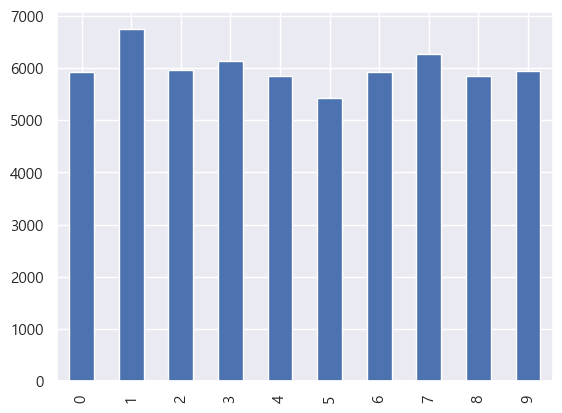

In [11]:
pd.Series(y_train).value_counts().sort_index().plot(kind = 'bar')
plt.show()

## 원하는 숫자 이미지

- 이미지 0

In [12]:
s = pd.Series(y_train)
idx_0 = s[s==0].index[:3]

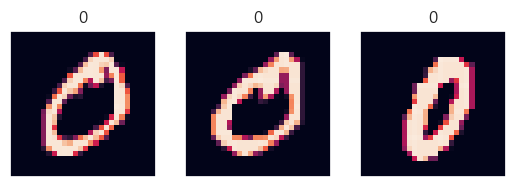

In [13]:
fig,ax = plt.subplots(1,3)
for i,idx in enumerate(idx_0):
    ax[i].imshow(X_train[idx])
    ax[i].set_title(y_train[idx])
    
    # Hide axes,grid ==========
    ax[i].grid(False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    # =========================
plt.show()

- 0~9까지 10개씩

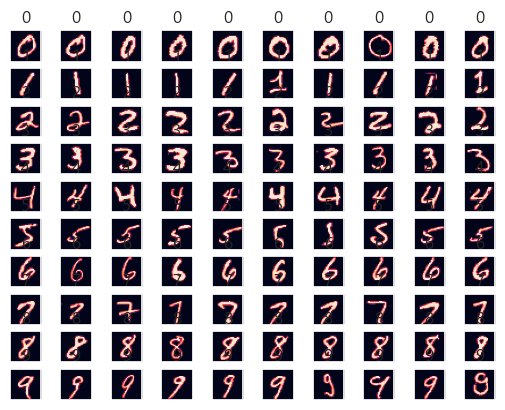

In [14]:
fig,ax = plt.subplots(10,10)
s = pd.Series(y_train)
for num in range(10):
    idx_list = s[s==num].index[:10]

    for i,idx in enumerate(idx_list):
        ax[num][i].imshow(X_train[idx])
        ax[num][i].set_title(y_train[idx])

        # Hide axes,grid ==========
        ax[num][i].grid(False)
        ax[num][i].set_xticks([])
        ax[num][i].set_yticks([])
        # =========================
        
plt.show()

# ML 전처리
- 전처리 1 : flatten
- 전처리 2 : 스케일링

## flatten
- flatten : 딥러닝 하기 위해서는 행렬을 1차로 reshape 해줘야 함
- 이미지 픽셀 (28*28) : 행렬(2D) -> arr(1D)

In [15]:
X_train.shape

(60000, 28, 28)

In [16]:
X_train.reshape(60000,-1).shape
# X_train.reshape(60000,784).shape

(60000, 784)

In [17]:
X_train.flatten().shape
# X_train.reshape(-1).shape

(47040000,)

In [18]:
# X_train[0]

In [19]:
X_train = X_train.reshape(60000,-1)
X_test = X_test.reshape(10000,-1)

## 정규화 (픽셀값(X값) 스케일링)
- 보통 minmaxscaler()사용 : 0-255 -> 255(흰색)이 더 중요하게 학습 될 가능성이 있음
    - 최대값 : 1, 최소값 : 0

In [20]:
X_train_scaler = X_train/255.0
X_test_scaler = X_test/255.0

In [21]:
X_train_scaler[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## target dummies()
- sklearn : OneHotEncoder()
- pd.get_dummies()
- keras : utils.to_categorical()
- 0 ~ 9 숫자 : 원핫인코딩
    - 0 : 1 0 0 0 0 0 0 0 0 0 
    - 1 : 0 1 0 0 0 0 0 0 0 0
    - 2 : 0 0 1 0 0 0 0 0 0 0
    - ....

In [22]:
from keras.utils import to_categorical
y_oh = to_categorical(y_train, num_classes = 10, dtype = 'int')
print(y_train[:5])
print(y_oh[:5])

[5 0 4 1 9]
[[0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]


In [23]:
from keras.utils import to_categorical
y_train_oh = to_categorical(y_train, num_classes = 10, dtype = 'int')
y_test_oh = to_categorical(y_test, num_classes = 10, dtype = 'int')
print(y_train_oh[:2])
print('---')
print(y_test_oh[:2])

[[0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]
---
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]]


# 모델 (Neural Network, FC)

## 모델&학습

In [32]:
from keras.layers import Dense
from keras import Sequential
from keras.initializers import GlorotNormal  #Xavier

In [33]:
model = Sequential()
model.add(Dense(units=300, input_dim=28*28, activation='relu', kernel_initializer='glorot_normal')) #입력층
model.add(Dense(units=100,  activation='relu'))              #히든레이어
model.add(Dense(units=60,  activation='relu'))              #히든레이어
model.add(Dense(units=10,  activation='softmax'))           #3종 출력층
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [34]:
fit_hisroty = model.fit(X_train_scaler, y_train_oh
                        , batch_size = 128
                        , validation_split=0.2, epochs=10)
print(fit_hisroty)
print ( model.evaluate(X_test_scaler, y_test_oh)  )

Epoch 1/10
375/375 [==============================] - 5s 9ms/step - loss: 0.3127 - accuracy: 0.9092 - val_loss: 0.1496 - val_accuracy: 0.9556
Epoch 2/10
375/375 [==============================] - 3s 8ms/step - loss: 0.1165 - accuracy: 0.9646 - val_loss: 0.1051 - val_accuracy: 0.9685
Epoch 3/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0759 - accuracy: 0.9770 - val_loss: 0.1004 - val_accuracy: 0.9707
Epoch 4/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0532 - accuracy: 0.9834 - val_loss: 0.0873 - val_accuracy: 0.9739
Epoch 5/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0379 - accuracy: 0.9885 - val_loss: 0.0999 - val_accuracy: 0.9734
Epoch 6/10
375/375 [==============================] - 4s 9ms/step - loss: 0.0327 - accuracy: 0.9892 - val_loss: 0.0877 - val_accuracy: 0.9754
Epoch 7/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0245 - accuracy: 0.9918 - val_loss: 0.1016 - val_accuracy: 0.9728
Epoch

## 평가 시각화

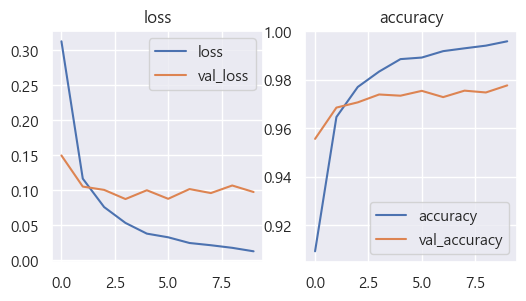

In [35]:
plt.figure(figsize=(6,3))
ax1 = plt.subplot(1,2,1)
ax1.plot(fit_hisroty.history['loss']    , label='loss')
ax1.plot(fit_hisroty.history['val_loss'], label='val_loss')
ax1.legend()
ax1.set_title("loss")

ax2 = plt.subplot(1,2,2)
ax2.plot(fit_hisroty.history['accuracy']    , label='accuracy')
ax2.plot(fit_hisroty.history['val_accuracy'], label='val_accuracy')
ax2.legend()
ax2.set_title("accuracy")

plt.show()

# 예측

## 예측

In [36]:
proba = model.predict(X_test_scaler)
proba[:3]

313/313 [==============================] - 1s 2ms/step


array([[9.50392760e-08, 4.53159743e-07, 1.80495505e-07, 2.33058545e-05,
        7.88468874e-11, 1.26011940e-07, 2.19508110e-11, 9.99874353e-01,
        4.79441610e-07, 1.00988298e-04],
       [2.15779512e-11, 8.85991653e-08, 9.99999881e-01, 7.32644112e-10,
        5.67125238e-20, 1.80434044e-14, 2.90337580e-11, 5.16306572e-12,
        4.08907040e-11, 3.78390476e-16],
       [4.23002646e-08, 9.99852419e-01, 1.37334437e-05, 1.18357324e-08,
        6.36575351e-07, 5.42174519e-07, 1.96047972e-06, 1.00271514e-04,
        3.03597135e-05, 2.17708642e-08]], dtype=float32)

In [37]:
pred = np.argmax(proba, axis = 1)
pred[:3]

array([7, 2, 1], dtype=int64)

## 오답 검증
- sklearn.metrics.confusion_matrix
- pandas.crosstab

### sklearn의 confusion_matrix

In [41]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(y_test,pred)
print(con_mat)

[[ 972    0    0    0    0    0    4    0    3    1]
 [   0 1126    3    1    0    0    3    0    2    0]
 [   4    0 1011    2    1    0    3    5    5    1]
 [   1    0    6  982    0   12    0    2    5    2]
 [   1    1    5    0  953    1    5    0    1   15]
 [   2    0    0    7    1  875    4    0    2    1]
 [   1    2    0    1    3    4  947    0    0    0]
 [   1    7    9    1    0    0    0 1001    4    5]
 [   1    0    3    8    1    3    4    4  945    5]
 [   3    4    1    2    6    3    0    3    1  986]]


### pandas의 crosstab

In [42]:
pd.crosstab(y_test,pred)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,972,0,0,0,0,0,4,0,3,1
1,0,1126,3,1,0,0,3,0,2,0
2,4,0,1011,2,1,0,3,5,5,1
3,1,0,6,982,0,12,0,2,5,2
4,1,1,5,0,953,1,5,0,1,15
5,2,0,0,7,1,875,4,0,2,1
6,1,2,0,1,3,4,947,0,0,0
7,1,7,9,1,0,0,0,1001,4,5
8,1,0,3,8,1,3,4,4,945,5


### 오답 idx 찾기

In [38]:
ans_df = pd.DataFrame({'y_test': y_test, 'pred':pred})
ans_df.head()

,y_test,pred
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


In [40]:
false_idx = ans_df[ans_df['y_test']!=ans_df['pred']].index

In [48]:
len(false_idx), ans_df.shape

(202, (10000, 2))

In [44]:
ans_df.loc[false_idx].head()

,y_test,pred
115,4,9
149,2,9
158,3,2
247,4,2
321,2,7


In [61]:
pd.Series(y_test[false_idx]).value_counts()

4    29
8    29
3    28
7    27
9    23
2    21
5    17
6    11
1     9
0     8
dtype: int64

In [78]:
xdf = ans_df.loc[false_idx]
xdf.head()

,y_test,pred
115,4,9
149,2,9
158,3,2
247,4,2
321,2,7


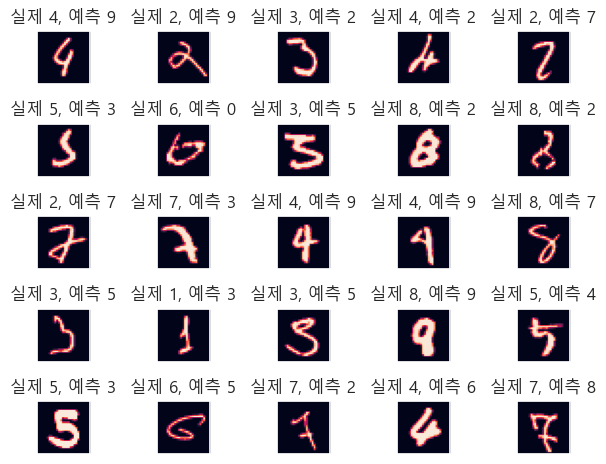

In [77]:
fig,ax = plt.subplots(5,10)
s = X_test[false_idx].reshape(202,28,28)[0:25]
for i,num_mat in enumerate(s):
    r = i//5
    c = i%5
    ax[r][c].imshow(num_mat)
    ax[r][c].set_title(f'실제 {y_test[false_idx][i]}, 예측 {pred[false_idx][i]}')

    # Hide axes,grid ==========
    ax[r][c].grid(False)
    ax[r][c].set_xticks([])
    ax[r][c].set_yticks([])
    
    # =========================
plt.tight_layout()        
plt.show()

In [4]:
plt.figure(figsize=(25,40))
xdf = ans_df[ans_df['pred']!= ans_df['y_test']]
xdf = xdf.sort_values(by='y_test')

for i, idx in enumerate(xdf.index):
    plt.subplot(21,10,i+1)
    plt.title(f"실제:{xdf.loc[idx, 'y_test']} 예측:{xdf.loc[idx, 'pred']}")
    plt.imshow(X_test[idx].reshape(28,28))
    plt.axis('off')
    plt.grid(False)
    
# plt.tight_layout()    
plt.show()

NameError: name 'plt' is not defined

# 번외.사용자 데이터 예측
- https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html

In [79]:
# ! pip install ipywidgets

In [80]:
import ipywidgets as widgets
widgets.FloatSlider()

FloatSlider(value=0.0)

In [2]:
import ipywidgets as widgets
btn = widgets.FileUpload(
    accept='image/*',    #'.png', 'image/*,.pdf'
    multiple=True
)
display(btn)

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

In [3]:
btn.value

({'name': '1.png',
  'type': 'image/png',
  'size': 302,
  'content': <memory at 0x00000232DC632DC0>,
  'last_modified': datetime.datetime(2023, 4, 12, 5, 49, 54, 38000, tzinfo=datetime.timezone.utc)},
 {'name': '2.png',
  'type': 'image/png',
  'size': 350,
  'content': <memory at 0x00000232DC632E80>,
  'last_modified': datetime.datetime(2023, 4, 12, 5, 49, 20, 380000, tzinfo=datetime.timezone.utc)})

In [87]:
for dic in btn.value:
    display(widgets.Image(value=dic['content'].tobytes()))

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x02\x00\x00\x00\xfdoH\xc…

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x02\x00\x00\x00\xfdoH\xc…

1.png  302
2.png  350


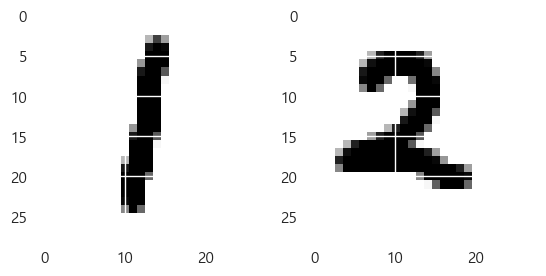

In [85]:
from PIL import Image
import io
for i, dic in enumerate(btn.value):
    plt.subplot(1,2,i+1)
    print(f"{dic['name']}  {dic['size']}")
    widgets.Image(value=dic['content'].tobytes())
    
    img = Image.open(  io.BytesIO(dic['content'])  ) #.resize(28,28) 
    plt.imshow(img)

name : 1.png, size : 302
(28, 28, 3) (28, 28)
1/1 [==============================] - 0s 33ms/step
예측값 :  1
name : 2.png, size : 350
(28, 28, 3) (28, 28)
1/1 [==============================] - 0s 28ms/step
예측값 :  2


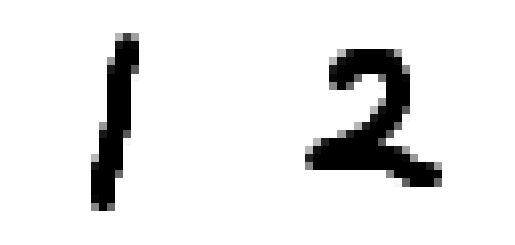

In [102]:
from PIL import Image # 파이썬 이미지 라이브러리에 있는 Image
import io
for i, dic in enumerate(btn.value):
    plt.subplot(1,len(btn.value),i+1)
    print(f"name : {dic['name']}, size : {dic['size']}")
    
    # ------------------------------------------------
    # addr = dic['content']                    # 메모리주소
    # binary_byte = dic['content'].tobytes()   # 주소를 바이트로 꺼냄   
    # io_object = io.BytesIO(addr)             # 주소를 객체로 읽고 쓰게 해줘
    # print(addr, binary_byte, io_object)
    
    # ------------------------------------------------
    # display(widgets.Image(value=dic.content.tobytes())) # 이미지를 보여줌
    # ------------------------------------------------
    img = Image.open(io.BytesIO(dic['content']))#.resize((28, 28)) 
    plt.imshow(img)
    plt.axis('off')
    plt.grid('False')
    # ------------------------------------------------
    
    # ==================== === 학습 형식 맞추기 === ================
    
    # ------ 차원 축소 (28, 28) ----------------------------------
    print(np.array(img).shape,  np.array(img)[:, :, 1].shape) 
    # (28, 28, 3) (28, 28)    
    img = np.array(img)[:, :, 1]
    # (28, 28)
    # -----------------------------------------------------------

    
    # ------ reshape (28, 28) -> (1,28,28) -> (1, 784) ----------
    img = img.reshape(1,-1)
    # print(img.shape)   # (1, 784)
    # -----------------------------------------------------------
    
    # ------ 이미지 스케일링 --------------------------------------
    img_scaler = (255-img)/255.0    # 이미지 스케일링 0 ~ 1 + 색반전
    # img_scaler = 255/255.0        # 이미지 스케일링 0 ~ 1
    # -----------------------------------------------------------
    
    proba = model.predict(img_scaler)
    print(f'예측값 :  {np.argmax(proba)}')
    
    # ============================================================


# 번외. fashion_mnist
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html


In [104]:
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [108]:
train_images.shape, train_labels.shape, 

(60000, 28, 28)

In [ ]:
LABEL_NAME__ = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

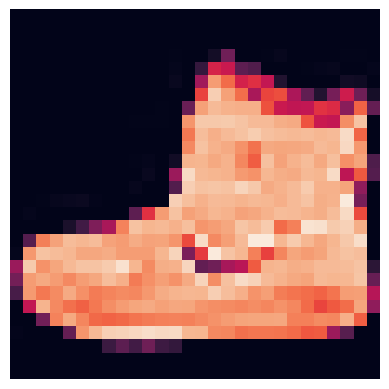

In [107]:
plt.imshow(train_images[0])
plt.axis('off')
plt.show()